In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 999)

In [2]:
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor

In [6]:
df = pd.read_csv('Fire_Dep_Call_50%.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
cols = ['Available DtTm', 'Response DtTm', 'Dispatch DtTm', 'Received DtTm']
for col in cols:
    df[col] = pd.to_datetime(df[col], format='%m/%d/%Y %I:%M:%S %p', infer_datetime_format=True)

df['Respond to Available'] = df['Available DtTm'] - df['Response DtTm']
df['Call to Dispatch'] = df['Dispatch DtTm'] - df['Received DtTm']

time_cols = ['Respond to Available', 'Call to Dispatch']
df[time_cols] = df[time_cols].applymap(lambda t: t.total_seconds())
df[time_cols] = df[time_cols].applymap(lambda x: max(x,0))

In [8]:
df['Month'] = df['Received DtTm'].dt.month
df['WeekDay'] = df['Received DtTm'].dt.weekday
df['Weekofyear'] = df['Received DtTm'].dt.weekofyear
df['Hours'] = df['Received DtTm'].dt.hour
df['Minutes'] = df['Received DtTm'].dt.minute

#---------added----------columns for hospital or transport
df['Hospital or Transport'] = (~(df['Transport DtTm'].isna() & df['Hospital DtTm'].isna())).astype('int')

In [241]:
df['Hospital or Transport'] =df['Hospital or Transport'].astype(bool)

In [243]:
def fill_na(df):
    q = df['Original Priority'].value_counts(normalize=True) #counts share of valeus in col w/o N/A
    orig_prio_list = q.index.tolist()  #makes indeces(priorities types) to a list
    orig_prio_shares = q.tolist() #makes values of shares a list
    df['Original Priority'] = df['Original Priority'].fillna(pd.Series(np.random.choice(orig_prio_list, p=orig_prio_shares, size=len(df))))

    w = df['Call Type Group'].value_counts(normalize=True) #counts share of values in col w/o N/A
    call_types_list = w.index.tolist()  #makes indeces(priorities types) to a list
    call_types_shares = w.tolist() #makes values of shares a list
    df['Call Type Group'] = df['Call Type Group'].fillna(pd.Series(np.random.choice(call_types_list, p=call_types_shares, size=len(df))))
    
fill_na(df)

if((df['Zipcode of Incident'].nunique()) <= (df['Neighborhooods - Analysis Boundaries'].nunique())):
    zipcodes = df[['Neighborhooods - Analysis Boundaries','Zipcode of Incident']]
    zipcodes = zipcodes[zipcodes['Zipcode of Incident'].notnull()]
    zips= list(zipcodes['Zipcode of Incident'].values)
    nbhds= list(zipcodes['Neighborhooods - Analysis Boundaries'].values)
    if len(zips) == len(nbhds):
        zipcodes_dict=dict(zip(nbhds,zips))

    else: 
        print('Count unique zipcodes != count neighborhooods, something went wrong.')
else:
    print('More zipcodes than neighborhooods, we need new strategy!')

df['Zipcode of Incident'] = df['Zipcode of Incident'].fillna(df['Neighborhooods - Analysis Boundaries'].map(zipcodes_dict))
df['Zipcode of Incident'] = df['Zipcode of Incident'].astype(int)

In [380]:
df.isnull().sum()

Call Number                                   0
Unit ID                                       0
Incident Number                               0
Call Type                                     0
Call Date                                     0
Watch Date                                    0
Received DtTm                                 0
Entry DtTm                                    0
Dispatch DtTm                                 0
Response DtTm                                 0
On Scene DtTm                            417390
Transport DtTm                          1483056
Hospital DtTm                           1587076
Call Final Disposition                        0
Available DtTm                                0
Address                                       0
City                                          0
Zipcode of Incident                           0
Battalion                                     0
Station Area                                  4
Box                                     

In [244]:
df['Location'] = df['Location'].astype(tuple)
locations = df['Location'].str[1:-1].str.split(',', expand=True).astype(float)
df[locations.columns]= abs(locations)

In [245]:
df['Unit_Type_Rolling'] = df.groupby('Unit Type')['Respond to Available'].rolling(10,min_periods=1).mean().reset_index(0,drop=True)
df['Call_Type_Rolling'] = df.groupby('Call Type')['Respond to Available'].rolling(10,min_periods=1).mean().reset_index(0,drop=True)
df['Unit_ID_Rolling'] = df.groupby('Unit ID')['Respond to Available'].rolling(10,min_periods=1).mean().reset_index(0,drop=True)

In [246]:
df.shape

(2030448, 47)

In [247]:
#only not null, not zero and less that 10 hours to solve
df1 = df[(df['Respond to Available'].notnull()) & (df['Respond to Available'] <= 21600) & (df['Respond to Available']>25)]

In [131]:
##THIS IS THE BEST DO NOT DELETE
#------cancelled dropping of 'Call to Dispatch','Minutes','Month', 'WeekDay', 'Call Type', 
df1 = df.drop(columns=['Call Number', 'Incident Number', 'Call Type Group', 'Call Date', 'Watch Date', 
                      'Received DtTm', 'Entry DtTm', 'Dispatch DtTm','Response DtTm', 'On Scene DtTm',
                      'Transport DtTm','Hospital DtTm', 'Call Final Disposition', 'Available DtTm',
                      'Supervisor District', 'Original Priority',
                      'Address', 'City', 'Priority', 'Final Priority',  'Location', 'Month', 'WeekDay',  
                      'RowID', 'Battalion', 'ALS Unit'], errors='ignore')

In [335]:
df1 = df.drop(columns=['Call Number', 'Incident Number', 'Call Date', 'Watch Date', 
                      'Received DtTm', 'Entry DtTm', 'Dispatch DtTm','Response DtTm', 'On Scene DtTm',
                      'Transport DtTm','Hospital DtTm', 'Call Final Disposition', 'Available DtTm',
                      'Supervisor District', 'Call Type Group','Month', 'WeekDay', 'Fire Prevention District',
                      'Address', 'City', 'Priority', 'Final Priority',  'Location', 
                      'RowID', 'Battalion', 'ALS Unit'], errors='ignore')

In [336]:
df1 = df1[df1['Neighborhooods - Analysis Boundaries']!='None']

In [337]:
df1 = df1.dropna(how='any') 

In [338]:
df1.shape

(2027071, 21)

# rolling 10  min2 :
511.89 /
599091.69 /
774.0101 /
0.7838


# rolling 15  min3 :
528.22 /
651249.47 /
807.000 /
0.7649


# rolling 15  min5 :
537.210 /
678675.26 /
823.817 /
0.755


## rolling 20  min3 :
551.853 /
730048.053 /
854.4284/
0.7366


## rolling 20  min5 :
550.92 /
729686.237 /
854.2167/
0.73667


## rolling 50  min5 :
573.0135 /
838835.43 /
915.879/
0.73667


In [339]:
y = df1['Respond to Available']
X = df1.drop(columns=['Respond to Available'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [340]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1418949 entries, 1 to 1647994
Data columns (total 20 columns):
Unit ID                                 1418949 non-null object
Call Type                               1418949 non-null object
Zipcode of Incident                     1418949 non-null int64
Station Area                            1418949 non-null object
Box                                     1418949 non-null float64
Original Priority                       1418949 non-null object
Number of Alarms                        1418949 non-null int64
Unit Type                               1418949 non-null object
Unit sequence in call dispatch          1418949 non-null int64
Neighborhooods - Analysis Boundaries    1418949 non-null object
Call to Dispatch                        1418949 non-null float64
Weekofyear                              1418949 non-null int64
Hours                                   1418949 non-null int64
Minutes                                 1418949 non-null i

In [342]:
cat_features=[
    0,
    1,
    3,
    5,
    7,
    9
]

In [343]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, cat_features=cat_features)

In [ ]:
model = CatBoostRegressor(iterations=100, depth=12,learning_rate=0.1, one_hot_max_size=3, logging_level='Info')
model.fit(train_pool)

Borders for float features generated

Hospital or Transport, bin=0 score 2137894.679
Number of Alarms, bin=0 score 2195809.733
Unit_ID_Rolling, bin=67 score 2229143.789
Call_Type_Rolling, bin=124 score 2251756.619
Unit_ID_Rolling, bin=110 score 2268378.897
Call_Type_Rolling, bin=83 score 2276166.383
Unit_Type_Rolling, bin=55 score 2287544.771
{Unit Type} pr2 tb0 type0, border=5 score 2295913.263
Unit_ID_Rolling, bin=82 score 2310050.168
Unit_Type_Rolling, bin=127 score 2311678.577
Call_Type_Rolling, bin=26 score 2317565.018
{Call Type} pr0 tb0 type1, border=4 score 2317159.7
0:	learn: 1974.7082242	total: 4.89s	remaining: 8m 3s

Hospital or Transport, bin=0 score 1921192.657
Call_Type_Rolling, bin=126 score 1975639.513
Unit_ID_Rolling, bin=71 score 2018101.717
Call_Type_Rolling, bin=91 score 2030511.44
Number of Alarms, bin=0 score 2041860.816
Unit_ID_Rolling, bin=113 score 2056112.807
{Unit Type} pr2 tb0 type0, border=4 score 2061221.494
Unit_Type_Rolling, bin=65 score 2073634.761
Unit

Unit_Type_Rolling, bin=127 score 601298.229
{Unit Type} pr0 tb0 type0, border=3 score 604164.9748
Unit_Type_Rolling, bin=91 score 609671.8986
{Unit Type} pr0 tb0 type0, border=10 score 615957.4788
Unit_Type_Rolling, bin=74 score 622219.0736
{Unit Type} pr0 tb0 type1, border=0 score 627107.9408
13:	learn: 972.3363921	total: 59.6s	remaining: 6m 6s

Hospital or Transport, bin=0 score 489572.6206
Call_Type_Rolling, bin=126 score 506804.7423
Unit_ID_Rolling, bin=75 score 522881.4482
Unit_Type_Rolling, bin=109 score 526011.2751
Unit_ID_Rolling, bin=115 score 533292.679
Unit_ID_Rolling, bin=21 score 537172.6648
Number of Alarms, bin=1 score 543491.4878
Unit_Type_Rolling, bin=30 score 549805.2467
{Unit Type} pr2 tb0 type0, border=9 score 552648.6682
Unit sequence in call dispatch, bin=8 score 556568.6809
Unit_Type_Rolling, bin=76 score 561912.5119
Call_Type_Rolling, bin=45 score 566289.2533
14:	learn: 949.9404709	total: 1m 3s	remaining: 6m 2s

Hospital or Transport, bin=0 score 440307.3595
Num

In [ ]:
pred = model.predict(test_pool)

In [ ]:
model.score(test_pool, y_test)  #

In [ ]:
XYY = X_test.copy()
XYY['y_test'] = y_test
XYY['y_pred'] = pred
XYY['y_test-y_pred'] = XYY['y_test']-XYY['y_pred']
XYY['y_test-y_pred_squared'] = XYY['y_test-y_pred']**2
mean_y = XYY['y_pred'].mean()
XYY['mean_y'] = mean_y
XYY['diff'] = XYY['y_test']-XYY['mean_y']
XYY.head(2)

In [ ]:
mae = (abs(XYY['y_test-y_pred']).sum())/len(XYY['y_test-y_pred'])
mse = (XYY['y_test-y_pred']**2).sum()/len(XYY['y_test-y_pred'])
rmse = mse**0.5
determanation_score = 1-((XYY['y_test-y_pred']**2).sum())/((XYY['diff']**2).sum())

In [ ]:
mae

In [ ]:
mse

In [512]:
rmse

774.1976435896896

In [513]:
determanation_score

0.7836156467278755

In [483]:
from sklearn.metrics import mean_squared_log_error

In [484]:
pred

array([ 337.59311806, 3550.75405627,  884.31753156, ...,  817.76655592,
        483.77403483,  733.13083877])

In [485]:
val = model.get_feature_importance()
feat = X_test.columns

list(zip(feat,val))

[('Unit ID', 1.6199747416439827),
 ('Call Type', 7.354440981896465),
 ('Zipcode of Incident', 0.6075044024757379),
 ('Station Area', 0.5026173477344364),
 ('Box', 0.5245439806105039),
 ('Original Priority', 0.8690457357085596),
 ('Number of Alarms', 2.467551029552304),
 ('Unit Type', 9.29745005171701),
 ('Unit sequence in call dispatch', 3.219516740353925),
 ('Neighborhooods - Analysis Boundaries', 0.80397605122979),
 ('Call to Dispatch', 1.2395897332769323),
 ('Weekofyear', 0.10065763922486516),
 ('Hours', 0.6796337479993786),
 ('Minutes', 0.11327479594568723),
 ('Hospital or Transport', 27.469854785644326),
 (0, 0.5310943026716185),
 (1, 0.4159651889029216),
 ('Unit_Type_Rolling', 8.880937847427953),
 ('Call_Type_Rolling', 14.99231911359934),
 ('Unit_ID_Rolling', 18.310051782384278)]

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

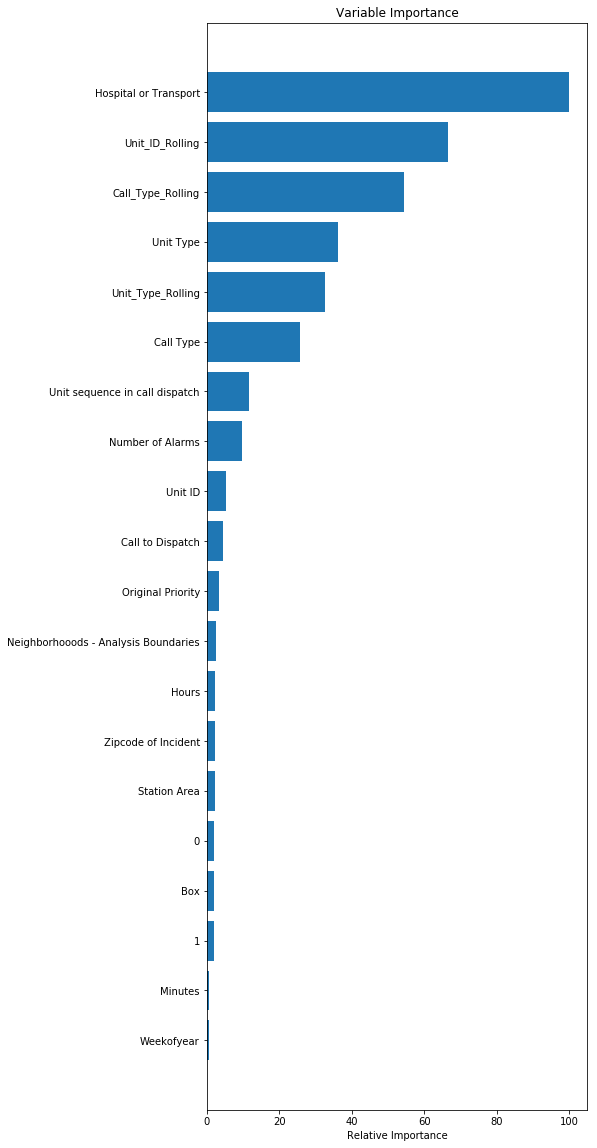

In [455]:
feature_importance = model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(15,20))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

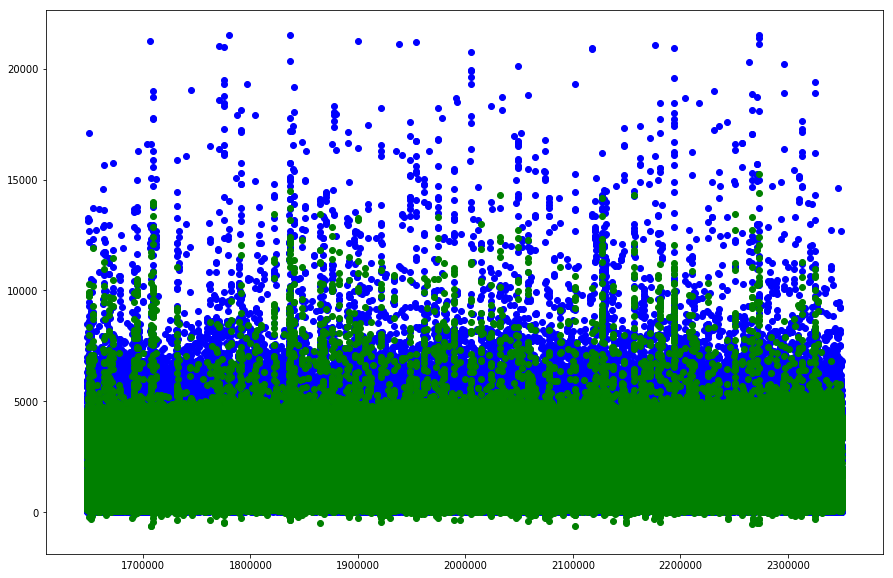

In [62]:
XYY = XYY.sort_values('y_test')
plt.figure(figsize=(15,10))
plt.scatter(XYY.index, XYY['y_test'].sort_values(), color='b')
plt.scatter(XYY.index, XYY['y_pred'], color='g')
plt.show()

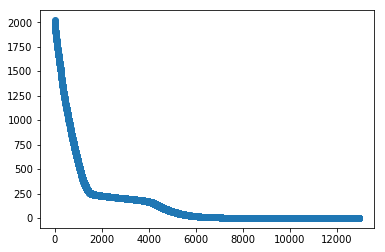

In [47]:
plt.scatter(range(0,12957), df1['Respond to Available'].value_counts())

In [408]:
from catboost import cv

In [ ]:
one_hot_max_size!!!!!!!!!!!!!!

In [429]:
pool_cv = Pool(X, y, cat_features=cat_features)

In [440]:
params = {'iterations': 150, 'depth': 12, 'loss_function': 'RMSE'}###one_hot_max_size!!!!!!!!!!!!!!
scores = cv(pool_cv, params, shuffle=False, fold_count=3, early_stopping_rounds=50)

0:	learn: 2142.7852405	test: 2141.7899456	best: 2141.7899456 (0)	total: 16.1s	remaining: 40m 5s
1:	learn: 2089.9805832	test: 2089.1627932	best: 2089.1627932 (1)	total: 30.3s	remaining: 37m 19s
2:	learn: 2038.7868082	test: 2037.8890362	best: 2037.8890362 (2)	total: 49s	remaining: 40m
3:	learn: 1989.3448104	test: 1988.3838390	best: 1988.3838390 (3)	total: 1m 10s	remaining: 42m 37s
4:	learn: 1941.6370955	test: 1940.6302436	best: 1940.6302436 (4)	total: 1m 24s	remaining: 41m 4s
5:	learn: 1895.6116041	test: 1894.6113305	best: 1894.6113305 (5)	total: 1m 40s	remaining: 40m 12s
6:	learn: 1851.2191489	test: 1850.2612011	best: 1850.2612011 (6)	total: 1m 56s	remaining: 39m 36s
7:	learn: 1808.4667696	test: 1807.5748369	best: 1807.5748369 (7)	total: 2m 12s	remaining: 39m 12s
8:	learn: 1767.1878634	test: 1766.4021088	best: 1766.4021088 (8)	total: 2m 25s	remaining: 38m 3s
9:	learn: 1727.5208340	test: 1726.8355560	best: 1726.8355560 (9)	total: 2m 38s	remaining: 37m 4s
10:	learn: 1689.2267295	test: 168

84:	learn: 836.4001239	test: 848.2500570	best: 848.2500570 (84)	total: 20m 22s	remaining: 15m 34s
85:	learn: 835.1266495	test: 847.0998775	best: 847.0998775 (85)	total: 20m 35s	remaining: 15m 19s
86:	learn: 833.8567312	test: 845.9559558	best: 845.9559558 (86)	total: 20m 51s	remaining: 15m 5s
87:	learn: 832.6537369	test: 844.9070999	best: 844.9070999 (87)	total: 21m 8s	remaining: 14m 53s
88:	learn: 831.5370940	test: 843.8926880	best: 843.8926880 (88)	total: 21m 20s	remaining: 14m 37s
89:	learn: 830.4721502	test: 842.9090074	best: 842.9090074 (89)	total: 21m 33s	remaining: 14m 22s
90:	learn: 829.4162948	test: 842.0037902	best: 842.0037902 (90)	total: 21m 46s	remaining: 14m 6s
91:	learn: 828.3770494	test: 840.9858691	best: 840.9858691 (91)	total: 21m 59s	remaining: 13m 51s
92:	learn: 827.3826849	test: 840.0270364	best: 840.0270364 (92)	total: 22m 12s	remaining: 13m 36s
93:	learn: 826.4394587	test: 839.2252339	best: 839.2252339 (93)	total: 22m 24s	remaining: 13m 21s
94:	learn: 825.4601549	

In [442]:
scores_rmse = scores

In [441]:
scores

,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,2141.789946,90.360944,2142.785241,45.000591
1,2089.162793,88.398576,2089.980583,43.097307
2,2037.889036,86.200994,2038.786808,41.312193
3,1988.383839,83.839675,1989.344810,39.534908
4,1940.630244,81.348751,1941.637095,37.948275
5,1894.611331,79.263799,1895.611604,36.309892
6,1850.261201,77.630555,1851.219149,34.759751
7,1807.574837,75.504606,1808.466770,33.304562
8,1766.402109,73.777250,1767.187863,31.827996
9,1726.835556,72.103789,1727.520834,30.382428
